In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib import colormaps

sys.path.append("C:/Users/haoyu/Documents/GitHub/XRaySimulation")

from XRaySimulation import Pulse, DeviceSimu, util, Crystal

plt.rcParams.update({'font.size': 22})


In [2]:
def prepare_beam_optics(miniSD_grating_position_1=3e6,
                        miniSD_grating_position_2=3e6,
                        miniSD_grating_period=1.0,
                        TG_grating_period=0.5,
                        TG_grating_position=2e6,
                        TG_mirror_probe_angle=np.deg2rad(np.array([1e-3, 12.012])),
                        TG_mirror_probe_position=np.array([2.5e6, 10.95e6]),
                        TG_mirror_pump_angle_y=np.deg2rad(np.array([0.4, 0.4])),
                        TG_mirror_pump_position=np.array([10.5e6, 10.5e6]),
                        ):
    """
    
    :param miniSD_grating_position_1: 
    :param miniSD_grating_position_2: 
    :param TG_grating_period: 
    :param TG_grating_position: 
    :param TG_mirror_probe_angle: 
    :param TG_mirror_probe_position: 
    :param TG_mirror_pump_angle_y: 
    :param TG_mirror_pump_position: 
    :return: 
    """
    # Specify the parameter here
    # --------------------------------------------------
    # X-ray parameter before the miniSD
    Ec = 9.5  # photon central energy in keV
    FWHM = 50  # beam transverse size in intensity FWHM (um)
    crystal_property = {'d': 1.9201 * 1e-4,
                        "chi0": complex(-0.97631E-05, 0.14871E-06),
                        "chih_sigma": complex(0.59310E-05, -0.14320E-06),
                        "chihbar_sigma": complex(0.59310E-05, -0.14320E-06),
                        "chih_pi": complex(0.46945E-05, -0.11201E-06),
                        "chihbar_pi": complex(0.46945E-05, -0.11201E-06),
                        }
    pre_length = 1e6

    my_pulse = Pulse.GaussianPulse3D()
    my_pulse.set_pulse_properties(central_energy=Ec,
                                  polar=[1., 0., 0.],
                                  sigma_x=FWHM / 2. / np.sqrt(np.log(2)) / util.c,
                                  sigma_y=FWHM / 2. / np.sqrt(np.log(2)) / util.c,
                                  sigma_z=9.,
                                  x0=np.array([0., 0., -pre_length - miniSD_grating_position_1]))

    # ----------------------------------------------------
    # Define gratings for the miniSD
    miniSD_gratings_cc = [Crystal.RectangleGrating(a=miniSD_grating_period / 2.,
                                                   b=miniSD_grating_period / 2.,
                                                   surface_point=np.array([0, 0, -miniSD_grating_position_1]),
                                                   order=-1.),
                          Crystal.RectangleGrating(a=miniSD_grating_period / 2.,
                                                   b=miniSD_grating_period / 2.,
                                                   surface_point=np.array([0, 0, miniSD_grating_position_2]),
                                                   order=1.)]

    miniSD_gratings_vcc = [Crystal.RectangleGrating(a=miniSD_grating_period / 2.,
                                                    b=miniSD_grating_period / 2.,
                                                    surface_point=np.array([0, 0, -miniSD_grating_position_1]),
                                                    order=1.),
                           Crystal.RectangleGrating(a=miniSD_grating_period / 2.,
                                                    b=miniSD_grating_period / 2.,
                                                    surface_point=np.array([0, 0, miniSD_grating_position_2]),
                                                    order=-1.)]

    # -----------------------------------------------------
    # Define grating for the TG
    TG_grating_a = Crystal.RectangleGrating(a=TG_grating_period / 2.,
                                            b=TG_grating_period / 2.,
                                            surface_point=np.array([0, 0, TG_grating_position]),
                                            order=-1.)
    TG_grating_b = Crystal.RectangleGrating(a=TG_grating_period / 2.,
                                            b=TG_grating_period / 2.,
                                            surface_point=np.array([0, 0, TG_grating_position]),
                                            order=1.)
    # ----------------------------------------------------
    # Define mirror for the pump pulse
    TG_mirror_pump_a = Crystal.TotalReflectionMirror(surface_point=np.array([0, 0, TG_mirror_pump_position[0]]),
                                                     normal=np.array([0,
                                                                      np.cos(TG_mirror_pump_angle_y[0]),
                                                                      -np.sin(TG_mirror_pump_angle_y[0])]))
    TG_mirror_pump_b = Crystal.TotalReflectionMirror(surface_point=np.array([0, 0, TG_mirror_pump_position[1]]),
                                                     normal=np.array([0,
                                                                      -np.cos(TG_mirror_pump_angle_y[1]),
                                                                      -np.sin(TG_mirror_pump_angle_y[1])]))

    # Define mirror for the probe pulse
    TG_mirror_probe_list = [Crystal.TotalReflectionMirror(surface_point=np.array([0, 0, TG_mirror_probe_position[0]]),
                                                          normal=np.array([-np.cos(TG_mirror_probe_angle[0]),
                                                                           0,
                                                                           np.sin(TG_mirror_probe_angle[0])])),
                            Crystal.TotalReflectionMirror(surface_point=np.array([0, 0, TG_mirror_pump_position[1]]),
                                                          normal=np.array([np.cos(TG_mirror_probe_angle[1]),
                                                                           0,
                                                                           np.sin(TG_mirror_probe_angle[1])]))]

    # -------------------------------------------------------------------------
    #                         VCC branch
    vcc_channel_cut_config = ["lower left", 'upper left', 'upper left', 'lower left']
    vcc_channel_cut_angles = np.deg2rad(np.array([[0, -5], [5., 0], [0, 5], [5, 0]]))
    vcc_channel_cut_edge_length_list = np.array([[50e3, 65.25e3],
                                                 [65.25e3, 50e3, ],
                                                 [50e3, 65.25e3],
                                                 [65.25e3, 50e3, ],
                                                 ])
    vcc_channel_cut_locations = np.array([[0, 0, 250e3],
                                          [0, 13.595e3, 250e3 + 178e3 - 32.5e3],
                                          [0, 0, 650e3, ],
                                          [0, -13.595e3, 650e3 + 175e3 + 32.5e3]])

    vcc_channel_cuts = [Crystal.ChannelCut(crystal_type="Silicon",
                                           miller_index="220",
                                           energy_keV=Ec,
                                           thickness_list=np.array([1e4, 1e4]),
                                           gap=13.595e3,
                                           surface_center_offset=32.5e3,
                                           edge_length_list=vcc_channel_cut_edge_length_list[_x],
                                           asymmetry_angle_list=vcc_channel_cut_angles[_x],
                                           first_surface_loc=vcc_channel_cut_config[_x],
                                           source=None,
                                           crystal_property=crystal_property)
                        for _x in range(4)]
    # Change the location of the crystals
    for idx in range(4):
        vcc_channel_cuts[idx].shift(displacement=vcc_channel_cut_locations[idx])

    # Align the angle of each crystal
    kout1 = DeviceSimu.get_kout_single_device(device=miniSD_gratings_vcc[0], kin=my_pulse.k0)
    fixed_surface_idx = [0, 1, 0, 1]
    for idx in range(4):
        kout2, _, _, _ = DeviceSimu.align_channel_cut_dynamical_bragg_reflection(channelcut=vcc_channel_cuts[idx],
                                                                                 kin=kout1,
                                                                                 rot_center=np.copy(
                                                                                     vcc_channel_cuts[idx].crystal_list[
                                                                                         fixed_surface_idx[
                                                                                             idx]].surface_point),
                                                                                 get_curve=True)
        kout1 = np.copy(kout2)

    # -----------------------------------------------------------------------------------
    #                      CC branch
    cc_channel_cut_config = ["upper left", 'lower left', ]
    cc_channel_cut_angles = np.deg2rad(np.array([[0, 0], [0, 0]]))
    cc_channel_cut_edge_length_list = np.array([[40e3, 100e3],
                                                [120e3, 15e3]])
    cc_channel_cut_center_offset = [30e3, 52.5e3]
    cc_channel_cut_gap = [25.15e3, 25.8e3]
    cc_channel_cut_locations = np.array([[0, 0, 0],
                                         [0, -cc_channel_cut_gap[1], 1050e3 - cc_channel_cut_center_offset[1]], ])

    cc_channel_cuts = [Crystal.ChannelCut(crystal_type="Silicon",
                                          miller_index="220",
                                          energy_keV=Ec,
                                          thickness_list=np.array([1e4, 1e4]),
                                          gap=cc_channel_cut_gap[_x],
                                          surface_center_offset=cc_channel_cut_center_offset[_x],
                                          edge_length_list=cc_channel_cut_edge_length_list[_x],
                                          asymmetry_angle_list=cc_channel_cut_angles[_x],
                                          first_surface_loc=cc_channel_cut_config[_x],
                                          source=None,
                                          crystal_property=crystal_property)
                       for _x in range(2)]

    # ------------------------------------------------------------------------------------
    # Change location of CC crystals
    for idx in range(2):
        cc_channel_cuts[idx].shift(displacement=cc_channel_cut_locations[idx])

    # Align the angle of each crystal
    kout1 = DeviceSimu.get_kout_single_device(device=miniSD_gratings_cc[0], kin=my_pulse.k0)
    fixed_surface_idx = [0, 1]
    for idx in range(2):
        kout2, _, _, _ = DeviceSimu.align_channel_cut_dynamical_bragg_reflection(channelcut=cc_channel_cuts[idx],
                                                                                 kin=kout1,
                                                                                 rot_center=np.copy(
                                                                                     cc_channel_cuts[idx].crystal_list[
                                                                                         fixed_surface_idx[
                                                                                             idx]].surface_point),
                                                                                 get_curve=True)
        kout1 = np.copy(kout2)

    # ---------------------------------------------------------------
    # Change the position of the TG optics according to the input parameters

    return (my_pulse, miniSD_gratings_cc, miniSD_gratings_vcc,
            vcc_channel_cuts, cc_channel_cuts,
            TG_grating_a, TG_grating_b,
            TG_mirror_pump_a, TG_mirror_pump_b, TG_mirror_probe_list)

In [3]:
def get_miniSD_and_TG_trajectory(displacement_list_vcc=np.zeros((4, 3)),
                                 displacement_list_cc=np.zeros((2, 3)),
                                 displacement_list_TG_probe=np.zeros((2, 3)),
                                 displacement_list_TG_pump=np.zeros((2, 3)),
                                 rotation_list_GT_probe=np.array([np.eye(3), np.eye(3)]),
                                 rotation_list_GT_pump=np.array([np.eye(3), np.eye(3)]),
                                 sample_plane_position=np.array([0, 0, 11e6]),
                                 sample_plane_normal=np.array([0, 0, -1]),
                                 ):
    """
    After thinking about this for a very long time, 
    I decided to define this clumsy function for this experiment only.
    
    Of course, I could have done this in a more general way such that
    the function can be resued for miniSD operation only.
    However, I do not have the bandwidth to do so at this moment.
    Therefore, I have to put everything together and hope to improve my 
    efficiency a little bit in this way.
     
    
    :param displacement_list_vcc: 
    :param displacement_list_cc: 
    :return: 
    """
    # Create a initial copy of the devices 
    (my_pulse,
     miniSD_gratings_cc,
     miniSD_gratings_vcc,
     vcc_channel_cuts,
     cc_channel_cuts,
     TG_grating_a,
     TG_grating_b,
     TG_mirror_pump_a,
     TG_mirror_pump_b,
     TG_mirror_probe_list) = prepare_beam_optics()
    
    
    # Move crystals in the miniSD as needed
    for idx in range(4):
        vcc_channel_cuts[idx].shift(displacement=displacement_list_vcc[idx])

    for idx in range(2):
        cc_channel_cuts[idx].shift(displacement=displacement_list_cc[idx])

    # Move devices in the TG optics as needed
    for idx in range(2):
        TG_mirror_probe_list[idx].shift(displacement_list_TG_probe[idx])
        TG_mirror_probe_list[idx].rotate(rot_mat=rotation_list_GT_probe[idx])

    # Move the TG pump optics as needed
    TG_mirror_pump_a.shift(displacement=displacement_list_TG_pump[0])
    TG_mirror_pump_a.rotate(rot_mat=rotation_list_GT_pump[0])
    TG_mirror_pump_b.shift(displacement=displacement_list_TG_pump[1])
    TG_mirror_pump_b.rotate(rot_mat=rotation_list_GT_pump[1])

    # Get a trajectory with this setting to find time 0
    device_list = [miniSD_gratings_vcc[0], ]
    for idx in range(4):
        device_list += vcc_channel_cuts[idx].crystal_list
    device_list += [miniSD_gratings_vcc[1], ]

    # Get the tranjectory for the miniSD VCC branch
    (vcc_trajectory_local,
     vcc_kout_list_local,
     vcc_path_local) = DeviceSimu.get_lightpath(device_list=device_list,
                                                kin=my_pulse.k0,
                                                initial_point=my_pulse.x0,
                                                final_plane_point=sample_plane_position,
                                                final_plane_normal=sample_plane_normal)

    # Get the tranjectory for the miniSD CC branch
    device_list = [miniSD_gratings_cc[0], ]
    for idx in range(2):
        device_list += cc_channel_cuts[idx].crystal_list
    device_list += [miniSD_gratings_cc[1], ]

    (cc_trajectory_local,
     cc_kout_list_local,
     cc_path_local) = DeviceSimu.get_lightpath(device_list=device_list,
                                               kin=my_pulse.k0,
                                               initial_point=my_pulse.x0,
                                               final_plane_point=sample_plane_position,
                                               final_plane_normal=sample_plane_normal)

    # Get the trajectory for the TG probe branch
    device_list = [miniSD_gratings_cc[0], ]
    for idx in range(2):
        device_list += cc_channel_cuts[idx].crystal_list
    device_list += TG_mirror_probe_list
    print(device_list)
    for tmp in device_list:
        print(tmp.surface_point)
        print(tmp.normal)
    
    # Get the tranjectory for the miniSD VCC branch
    (TG_probe_trajectory,
     TG_probe_kout_list,
     TG_probe_ligthPathLength) = DeviceSimu.get_lightpath(device_list=device_list,
                                                          kin=my_pulse.k0,
                                                          initial_point=my_pulse.x0,
                                                          final_plane_point=sample_plane_position,
                                                          final_plane_normal=sample_plane_normal)
    # Get the trajectory for the TG pump branch a
    device_list = [miniSD_gratings_vcc[0], ]
    for idx in range(4):
        device_list += vcc_channel_cuts[idx].crystal_list
    device_list += [TG_grating_a, TG_mirror_pump_a]

    # Get the tranjectory for the miniSD VCC branch
    (TG_pump_trajectory_a,
     TG_pump_kout_list_a,
     TG_pump_ligthPathLength_a) = DeviceSimu.get_lightpath(device_list=device_list,
                                                           kin=my_pulse.k0,
                                                           initial_point=my_pulse.x0,
                                                           final_plane_point=sample_plane_position,
                                                           final_plane_normal=sample_plane_normal)

    # Get the trajectory for the TG pump branch b
    device_list = [miniSD_gratings_vcc[0], ]
    for idx in range(4):
        device_list += vcc_channel_cuts[idx].crystal_list
    device_list += [TG_grating_b, TG_mirror_pump_b]

    # Get the tranjectory for the miniSD VCC branch
    (TG_pump_trajectory_b,
     TG_pump_kout_list_b,
     TG_pump_ligthPathLength_b) = DeviceSimu.get_lightpath(device_list=device_list,
                                                           kin=my_pulse.k0,
                                                           initial_point=my_pulse.x0,
                                                           final_plane_point=sample_plane_position,
                                                           final_plane_normal=sample_plane_normal)

    return {"devices": {'pulse': my_pulse,
                        "sd grating cc": miniSD_gratings_cc,
                        "sd grating vcc": miniSD_gratings_vcc,
                        "vcc": vcc_channel_cuts,
                        "cc": cc_channel_cuts,
                        "tg grating a": TG_grating_a,
                        "tg grating b": TG_grating_b,
                        'tg mirror pump a': TG_mirror_pump_a,
                        'tg mirror pump b': TG_mirror_pump_b,
                        'tg mirror probe': TG_mirror_probe_list,
                        },
            "vcc": {"trajectory": vcc_trajectory_local,
                    "kout": vcc_kout_list_local,
                    "pathLength": vcc_path_local},
            "cc": {"trajectory": cc_trajectory_local,
                   "kout": cc_kout_list_local,
                   "pathLength": cc_path_local},
            "TG probe": {"trajectory": TG_probe_trajectory,
                         "kout": TG_probe_kout_list,
                         "pathLength": TG_probe_ligthPathLength},
            "TG pump a": {"trajectory": TG_pump_trajectory_a,
                          "kout": TG_pump_kout_list_a,
                          "pathLength": TG_pump_ligthPathLength_a},
            "TG pump b": {"trajectory": TG_pump_trajectory_b,
                          "kout": TG_pump_kout_list_b,
                          "pathLength": TG_pump_ligthPathLength_b},
            }

In [4]:
def get_coefficient_for_two_configurations(config1, config2):
    # Get the influence on the VCC branch position
    sd_vcc_position_coef = config1['vcc']['trajectory'][-1] - config2['vcc']['trajectory'][-1]

    # Get the influence on the VCC path length
    sd_vcc_pathLength_coef = config1['vcc']['pathLength'] - config2['vcc']['pathLength']

    # Get the influence on the TG probe position
    tg_probe_position_coef = config1['TG probe']['trajectory'][-1] - config2['TG probe']['trajectory'][-1]

    # Get the influence on the TG probe path length  
    tg_probe_pathLength_coef = config1['TG probe']['pathLength'] - config2['TG probe']['pathLength']

    # Get the influence on the TG branch 1 position
    tg_pump_a_position_coef = config1['TG pump a']['trajectory'][-1] - config2['TG pump a']['trajectory'][-1]

    # Get the influence on the TG branch 1 path length
    tg_pump_a_pathLength_coef = config1['TG pump a']['pathLength'] - config2['TG pump a']['pathLength']

    # Get the influence on the TG branch 2 position
    tg_pump_b_position_coef = config1['TG pump b']['trajectory'][-1] - config2['TG pump b']['trajectory'][-1]

    # Get the influence on the TG branch s path length
    tg_pump_b_pathLength_coef = config1['TG pump b']['pathLength'] - config2['TG pump b']['pathLength']

    return ((sd_vcc_position_coef, sd_vcc_pathLength_coef),
            (tg_probe_position_coef, tg_probe_pathLength_coef),
            (tg_pump_a_position_coef, tg_pump_a_pathLength_coef),
            (tg_pump_b_position_coef, tg_pump_b_pathLength_coef))


def get_trajectory_dependence_on_various_parameters():
    """
    The purpose of this function is to calculate the dependence on various 
    crystal parameter on the resulting optics trajectory and 
    light path length dependene.
    
    :return: 
    """
    # Calculate the current trajectories for different light paths
    current = get_miniSD_and_TG_trajectory(displacement_list_vcc=np.zeros((4, 3)),
                                           displacement_list_cc=np.zeros((2, 3)),
                                           displacement_list_TG_probe=np.zeros((2, 3)),
                                           displacement_list_TG_pump=np.zeros((2, 3)),
                                           rotation_list_GT_probe=np.array([np.eye(3), np.eye(3)]),
                                           rotation_list_GT_pump=np.array([np.eye(3), np.eye(3)]),
                                           sample_plane_position=np.array([0, 0, 11e6]),
                                           sample_plane_normal=np.array([0, 0, -1]), )

    # T2x + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_vcc=np.array([[0, 1, 0], [0, 0, 0],
                                                                       [0, 0, 0], [0, 0, 0]]))
    t2x_coef = get_coefficient_for_two_configurations(new, current)

    # T3x + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_vcc=np.array([[0, 0, 0], [0, 1, 0],
                                                                       [0, 0, 0], [0, 0, 0]]))
    t3x_coef = get_coefficient_for_two_configurations(new, current)

    # T4x + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_vcc=np.array([[0, 0, 0], [0, 0, 0],
                                                                       [0, 1, 0], [0, 0, 0]]))
    t4x_coef = get_coefficient_for_two_configurations(new, current)

    # T5x + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_vcc=np.array([[0, 0, 0], [0, 0, 0],
                                                                       [0, 0, 0], [0, 1, 0]]))
    t5x_coef = get_coefficient_for_two_configurations(new, current)

    # probe1z + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_TG_probe=np.array([[0, 0, 1], [0, 0, 0]]))
    probe1z_coef = get_coefficient_for_two_configurations(new, current)

    # probe1_alpha + 1urad
    new = get_miniSD_and_TG_trajectory(rotation_list_GT_probe=np.array([[[1, 0, 0],
                                                                         [0, np.cos(1e-6), np.sin(1e-6)],
                                                                         [0, -np.sin(1e-6), np.cos(1e-6)]],
                                                                        np.eye(3)]))
    probe1alpha_coef = get_coefficient_for_two_configurations(new, current)

    # probe2z + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_TG_probe=np.array([[0, 0, 0], [0, 0, 1]]))
    probe2z_coef = get_coefficient_for_two_configurations(new, current)

    # probe2_alpha + 1urad
    # This is ignored since the second mirror is essentially a crystal
    # Therefore it is better if we optimize the intensity rather than the tune it.

    # TG1z + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_TG_pump=np.array([[0, 0, 1], [0, 0, 0]]))
    pump1z_coef = get_coefficient_for_two_configurations(new, current)

    # TG1_alpha + 1urad
    new = get_miniSD_and_TG_trajectory(rotation_list_GT_probe=np.array([[[np.cos(1e-6), 0, np.sin(1e-6)],
                                                                         [0, 1, 0],
                                                                         [-np.sin(1e-6), 0, np.cos(1e-6)]],
                                                                        np.eye(3)]))
    pump1alpha_coef = get_coefficient_for_two_configurations(new, current)

    # TG2z + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_TG_pump=np.array([[0, 0, 0], [0, 0, 1]]))
    pump2z_coef = get_coefficient_for_two_configurations(new, current)

    # TG2_alpha + 1urad
    new = get_miniSD_and_TG_trajectory(rotation_list_GT_probe=np.array([np.eye(3),
                                                                        [[np.cos(1e-6), 0, -np.sin(1e-6)],
                                                                         [0, 1, 0],
                                                                         [np.sin(1e-6), 0, np.cos(1e-6)]], ]))
    pump2alpha_coef = get_coefficient_for_two_configurations(new, current)

    return (t2x_coef, t3x_coef, t4x_coef, t5x_coef,
            probe1z_coef, probe1alpha_coef, probe2z_coef,
            pump1z_coef, pump1alpha_coef, pump2z_coef, pump2alpha_coef)


In [5]:
expSimu = get_miniSD_and_TG_trajectory()
(t2x_coef, t3x_coef, t4x_coef, t5x_coef,
 probe1z_coef, probe1alpha_coef, probe2z_coef,
 pump1z_coef, pump1alpha_coef, pump2z_coef,pump2alpha_coef) = get_trajectory_dependence_on_various_parameters()

[<XRaySimulation.Crystal.RectangleGrating object at 0x0000017DC18D5E20>, <XRaySimulation.Crystal.CrystalBlock3D object at 0x0000017DC4B7DDF0>, <XRaySimulation.Crystal.CrystalBlock3D object at 0x0000017DC4B7DE20>, <XRaySimulation.Crystal.CrystalBlock3D object at 0x0000017DC4B7DD90>, <XRaySimulation.Crystal.CrystalBlock3D object at 0x0000017DC4B7DD60>, <XRaySimulation.Crystal.TotalReflectionMirror object at 0x0000017DC493FFD0>, <XRaySimulation.Crystal.TotalReflectionMirror object at 0x0000017DC4B7D430>]
[       0.        0. -3000000.]
[0. 0. 1.]
[0. 0. 0.]
[0.         0.94043928 0.3399617 ]
[     0.         -33850.89899548  19663.14159023]
[ 0.         -0.94043928 -0.3399617 ]
[      0.          -42101.84918098 1009388.12617544]
[ 0.         -0.94051857  0.33974229]
[      0.       0. 1050000.]
[ 0.          0.94051857 -0.33974229]
[      0.       0. 2500000.]
[-1.00000000e+00  0.00000000e+00  1.74532925e-05]
[       0.        0. 10500000.]
[0.97810403 0.         0.20811655]
[<XRaySimula

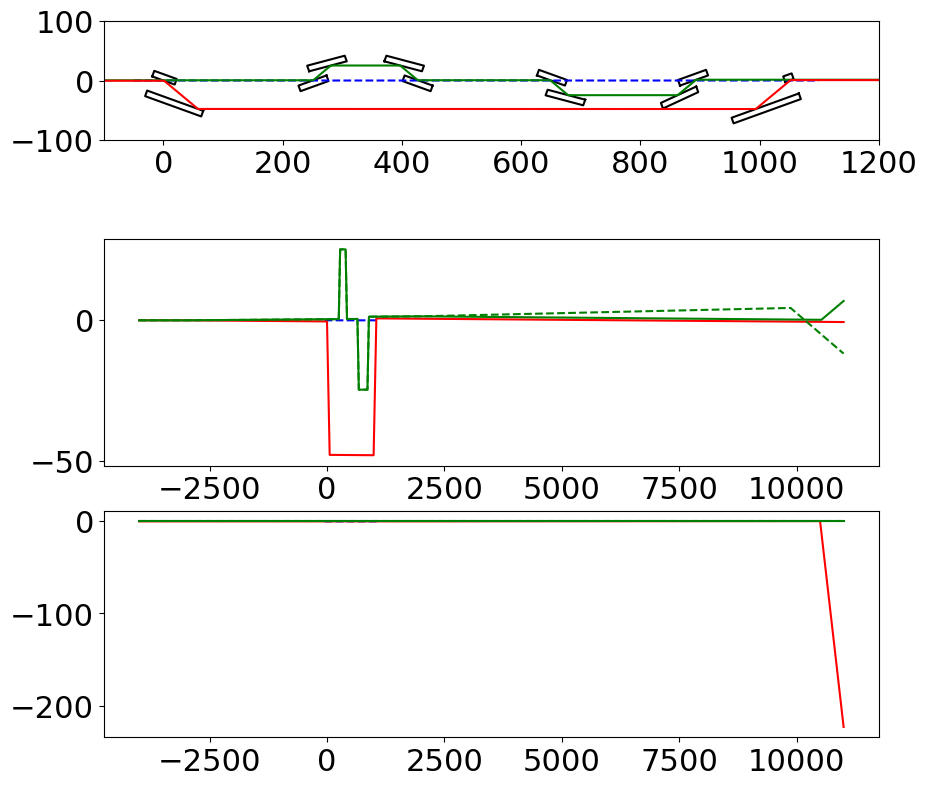

In [6]:
fig, axes = plt.subplots(ncols=1, nrows=3)

fig.set_figheight(10)
fig.set_figwidth(10)

# --------------------------------------------------------------------------
# Show the trajectory of the miniSD region
cmap = colormaps.get_cmap('spring')
for x in range(4):
    for idx in range(2):
        axes[0].plot(expSimu['devices']['vcc'][x].crystal_list[idx].boundary[:, 2] / 1000,
                     expSimu['devices']['vcc'][x].crystal_list[idx].boundary[:, 1] / 1000,
                     c='k')
        #c=cmap((x * 2 + idx) / 8))

for x in range(2):
    for idx in range(2):
        axes[0].plot(expSimu['devices']['cc'][x].crystal_list[idx].boundary[:, 2] / 1000,
                     expSimu['devices']['cc'][x].crystal_list[idx].boundary[:, 1] / 1000,
                     c='k')

# Plot a horizontal reference line
axes[0].plot(np.arange(-50, 1100), np.zeros(1150), c='b', linestyle='--')

# Plot the miniSD trajectory
axes[0].plot(expSimu['vcc']['trajectory'][:, 2] / 1000,
             expSimu['vcc']['trajectory'][:, 1] / 1000, 'g')

axes[0].plot(expSimu['cc']['trajectory'][:, 2] / 1000,
             expSimu['cc']['trajectory'][:, 1] / 1000, 'r')

axes[0].set_aspect("equal")
axes[0].set_ylim([-100, 100])
axes[0].set_xlim([-100, 1200])

# --------------------------------------------------------------------------
# Show the TG part in the x-z plane

# Plot a horizontal reference line
axes[1].plot(np.arange(-50, 1100), np.zeros(1150), c='b', linestyle='--')

# Plot the miniSD trajectory
axes[1].plot(expSimu['TG probe']['trajectory'][:, 2] / 1000,
             expSimu['TG probe']['trajectory'][:, 1] / 1000, 'r')

axes[1].plot(expSimu['TG pump a']['trajectory'][:, 2] / 1000,
             expSimu['TG pump a']['trajectory'][:, 1] / 1000, 'g')

axes[1].plot(expSimu['TG pump b']['trajectory'][:, 2] / 1000,
             expSimu['TG pump b']['trajectory'][:, 1] / 1000, 'g--')

#axes[1].set_aspect("equal")
#axes[1].set_ylim([-10, 10])
#axes[1].set_xlim([-100, 1200])

# --------------------------------------------------------------------------
# Show the TG part in the y-z plane

# Plot a horizontal reference line
axes[2].plot(np.arange(-50, 1100), np.zeros(1150), c='b', linestyle='--')

# Plot the miniSD trajectory
axes[2].plot(expSimu['TG probe']['trajectory'][:, 2] / 1000,
             expSimu['TG probe']['trajectory'][:, 0] / 1000, 'r')

axes[2].plot(expSimu['TG pump a']['trajectory'][:, 2] / 1000,
             expSimu['TG pump a']['trajectory'][:, 0] / 1000, 'g')

axes[2].plot(expSimu['TG pump b']['trajectory'][:, 2] / 1000,
             expSimu['TG pump b']['trajectory'][:, 0] / 1000, 'g--')

#axes[2].set_aspect("equal")
#axes[2].set_ylim([-10, 10])
#axes[2].set_xlim([1000, 1200])


plt.show()

# Step 2: Create grating and mirrors for the transient grating

In [7]:
expSimu['cc']['trajectory']


array([[ 0.00000000e+00,  0.00000000e+00, -4.00000000e+06],
       [ 0.00000000e+00,  0.00000000e+00, -3.00000000e+06],
       [ 0.00000000e+00, -3.91670449e+02,  1.08348168e+03],
       [ 0.00000000e+00, -4.77054247e+04,  5.79890474e+04],
       [ 0.00000000e+00, -4.78275229e+04,  9.93537575e+05],
       [ 0.00000000e+00,  6.93327967e+02,  1.05191936e+06],
       [ 0.00000000e+00,  4.39084583e+02,  3.00000000e+06],
       [ 0.00000000e+00,  4.39084583e+02,  1.10000000e+07]])

In [8]:
expSimu['TG pump a']['trajectory']

array([[ 0.00000000e+00,  0.00000000e+00, -4.00000000e+06],
       [ 0.00000000e+00,  0.00000000e+00, -3.00000000e+06],
       [ 0.00000000e+00,  4.24309641e+02,  2.51173678e+05],
       [ 0.00000000e+00,  2.51559833e+04,  2.80916067e+05],
       [ 0.00000000e+00,  2.51702136e+04,  3.96995574e+05],
       [ 0.00000000e+00,  4.59771681e+02,  4.26727255e+05],
       [ 0.00000000e+00,  4.85221258e+02,  6.48656805e+05],
       [ 0.00000000e+00, -2.45936677e+04,  6.78831802e+05],
       [ 0.00000000e+00, -2.45711552e+04,  8.62468899e+05],
       [ 0.00000000e+00,  1.29107039e+03,  8.93571334e+05],
       [ 0.00000000e+00,  1.41981447e+03,  2.00000000e+06],
       [ 0.00000000e+00,  1.86348936e+02,  1.05266921e+07],
       [ 0.00000000e+00,  6.86388551e+03,  1.10000000e+07]])

In [9]:
expSimu['TG probe']['kout']


array([[ 0.00000000e+00,  0.00000000e+00,  4.81434422e+04],
       [ 0.00000000e+00, -6.28318531e+00,  4.81434422e+04],
       [ 0.00000000e+00, -3.07793705e+04,  3.70192034e+04],
       [ 0.00000000e+00, -6.28318531e+00,  4.81434422e+04],
       [ 0.00000000e+00,  3.07717593e+04,  3.70255303e+04],
       [ 0.00000000e+00, -6.28318531e+00,  4.81434422e+04],
       [ 1.68052316e+00, -6.28318531e+00,  4.81434422e+04],
       [-1.96016581e+04, -6.28318531e+00,  4.39723325e+04]])

In [10]:
expSimu['cc']['kout']


array([[ 0.00000000e+00,  0.00000000e+00,  4.81434422e+04],
       [ 0.00000000e+00, -6.28318531e+00,  4.81434422e+04],
       [ 0.00000000e+00, -3.07793705e+04,  3.70192034e+04],
       [ 0.00000000e+00, -6.28318531e+00,  4.81434422e+04],
       [ 0.00000000e+00,  3.07717593e+04,  3.70255303e+04],
       [ 0.00000000e+00, -6.28318531e+00,  4.81434422e+04],
       [ 0.00000000e+00,  4.39648318e-13,  4.81434422e+04]])